In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

eigenvec_df = pd.read_csv("../PCA/eigenvec_100PC.csv", index_col=[0])
who_variants_combined = pd.read_csv("who_confidence_2021.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False).query("Sample_ID in @eigenvec_df.index")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# solo_initial_results = pd.read_excel("../results/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)

# # remove the first row for now -- it denotes variables for ALL and WHO results, but cumbersome to handle in pandas
# solo_final_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1])

# if len(solo_initial_results) == 1:
#     solo_initial_results = solo_initial_results[list(solo_initial_results.keys())[0]]
solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1]).query("tier==1")

# solo_binary_stats = pd.read_excel("~/who-analysis/results/sens_spec_19Jul2023.xlsx", sheet_name=None)

# if len(solo_binary_stats) == 1:
#     solo_binary_stats = solo_binary_stats["Sheet1"]

# # get only the relevant group for comparison to regression
# solo_binary_stats = solo_binary_stats.loc[(~pd.isnull(solo_binary_stats["TAB"])) & (solo_binary_stats["TAB"].str.contains('3'))][["drug", "Sens", "Spec", "PPV", "NPV", "propR", "PPV_lb", 'PPV_ub', 'NPV_lb', 'NPV_ub', 'Sens_lb', 'Sens_ub', 'Spec_lb',
#        'Spec_ub', 'propR_lb', 'propR_ub', 'TP', 'TN', 'FP', 'FN']].rename(columns={"propR": "PropR", "propR_lb": "PropR_lb", "propR_ub": "PropR_ub"})

# solo_binary_stats[["Sens", "Spec", "PPV", "NPV", "PPV_lb", 'PPV_ub', 'NPV_lb', 'NPV_ub', 'Sens_lb', 'Sens_ub', 'Spec_lb',
#        'Spec_ub', "PropR", "PropR_lb", "PropR_ub"]] /= 100

solo_binary_stats = pd.read_csv("../results/solo_binary_stats_Aug2023.csv")
solo_binary_stats["Model"] = "SOLO"
solo_binary_stats = solo_binary_stats.set_index("Model")
print(solo_binary_stats.shape)

drugs_lst = list(drug_abbr_dict.keys())

(49113, 7)
(15, 23)


In [2]:
single_lineages = lineages.query("~Coll2014.str.contains(',')")

# percent mixed lineage samples
print((len(lineages)-len(single_lineages)) / len(lineages))

# add primary lineage column
for i, row in single_lineages.iterrows():
    if row["Coll2014"][0].isnumeric():
        single_lineages.loc[i, "Lineage"] = row["Coll2014"][0]
    else:
        single_lineages.loc[i, "Lineage"] = row["Coll2014"]

0.010669272901268503


# 0. Correlations Between Lineages and Each PC

In [3]:
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                   "BOV": "gray",
                   "BOV_AFRI": "black"
                  }

def plot_PCA_colored_by_lineage(lineage_df, eigenvec_df, pc_x, pc_y, include_lineages=None, color_col="Lineage", color_dict=None, saveName=None):

    if include_lineages is None:
        include_lineages = lineage_df.Lineage.unique()
        color_col = "Lineage"
        color_dict = LinToColor_Dict
    else:
        color_dict = None
        
    plot_df = lineage_df.query("Lineage in @include_lineages").merge(eigenvec_df, left_on="Sample_ID", right_index=True, how="inner")
        
    fig, ax = plt.subplots(figsize=(5, 4))
    
    if color_dict is None:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        alpha=0.7,
                        s=20,
                        ax=ax
                        )
    else:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        hue_order=np.sort(include_lineages),
                        palette=color_dict,
                        alpha=0.7,
                        s=20,
                        ax=ax
                        )
    
    sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))

    # for lh in ax._legend.legendHandles: 
    #     lh._sizes = [10] 
    #     # You can also use lh.set_sizes([50])

    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

In [4]:
scaler = StandardScaler()

combined_single_lineage_PC = pd.get_dummies(single_lineages.set_index("Sample_ID")["Lineage"]).astype(int).merge(eigenvec_df, left_index=True, right_index=True)

def get_lineage_correlations_with_PC(lineage, sig_thresh=0.01):

    single_lineage_pvals = pd.DataFrame(columns=["rho", "pval", "PC", "abs_rho"])
    
    for i, col in enumerate(combined_single_lineage_PC.columns[combined_single_lineage_PC.columns.str.contains("PC")]):
    
        # rho, pval = st.pointbiserialr(combined_single_lineage_PC[lineage].values, combined_single_lineage_PC[col].values)
        rho, pval = st.pearsonr(np.squeeze(scaler.fit_transform(combined_single_lineage_PC[lineage].values.reshape(-1, 1))), 
                                combined_single_lineage_PC[col].values
                               )
        
        single_lineage_pvals.loc[i, :] = [rho, pval, int(col.replace("PC", "")), np.abs(rho)]
    
    single_lineage_pvals["Bonferroni_pval"] = np.min([single_lineage_pvals["pval"] * len(single_lineage_pvals), np.ones(len(single_lineage_pvals))], axis=0)
    return single_lineage_pvals.query("Bonferroni_pval < @sig_thresh").sort_values("abs_rho", ascending=False)

In [5]:
lineage_corr_dict = {}

for lineage in np.sort(single_lineages.Lineage.unique()):

    num_lineage = len(single_lineages.query("Lineage==@lineage"))
    
    if num_lineage / len(single_lineages) >= 0.005:
        lineage_corr_dict[lineage] = get_lineage_correlations_with_PC(lineage)

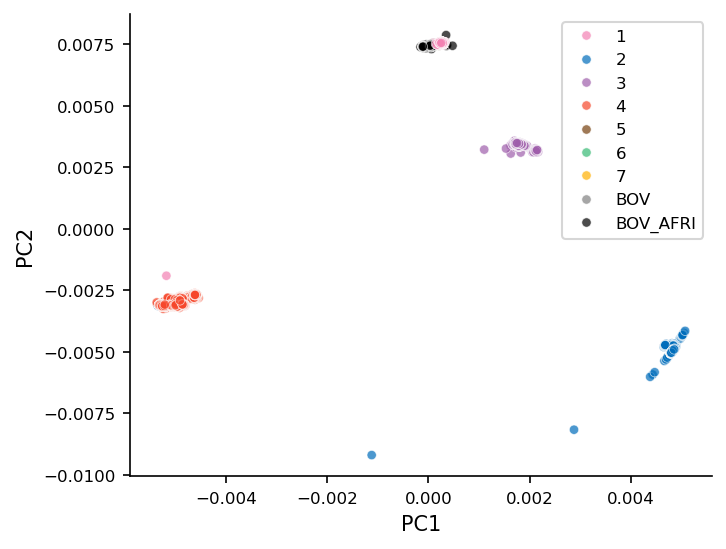

In [17]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC1', pc_y='PC2', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC1_PC2.png'
                           )

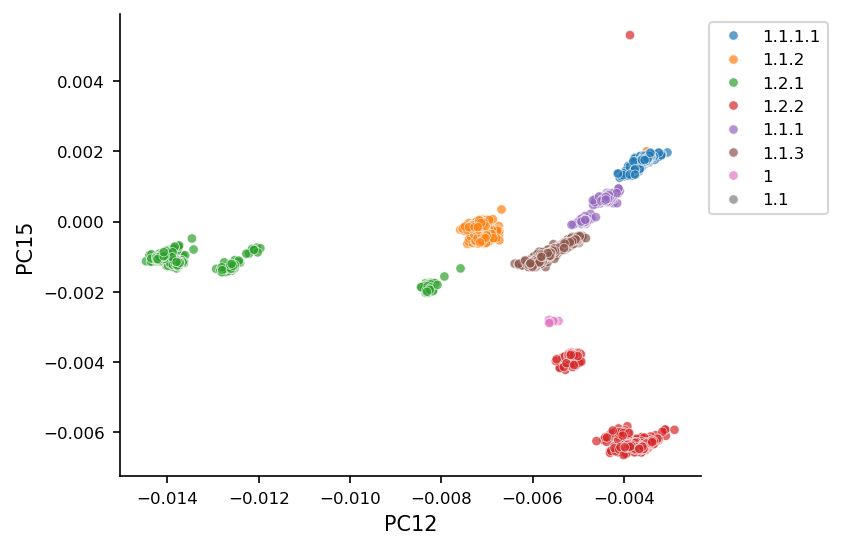

In [18]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC12', pc_y='PC15', 
                            include_lineages=["1"],
                            color_col="Coll2014", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC12_PC15_L1.png'
                           )

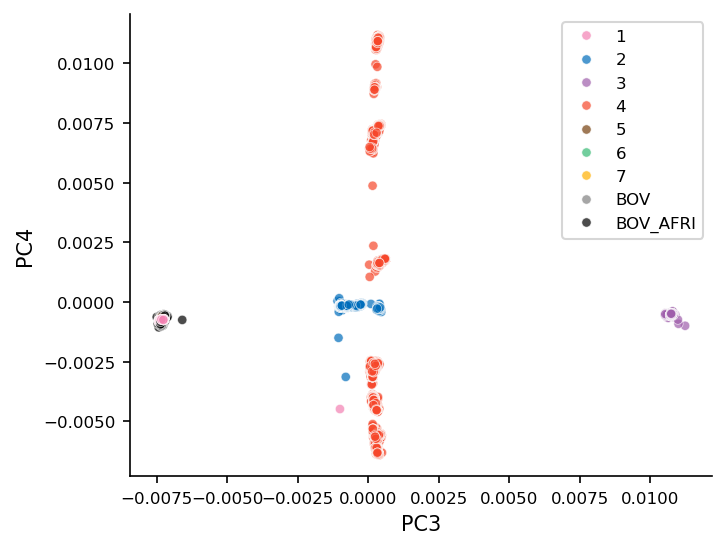

In [19]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC3', pc_y='PC4', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC3_PC4.png'
                           )

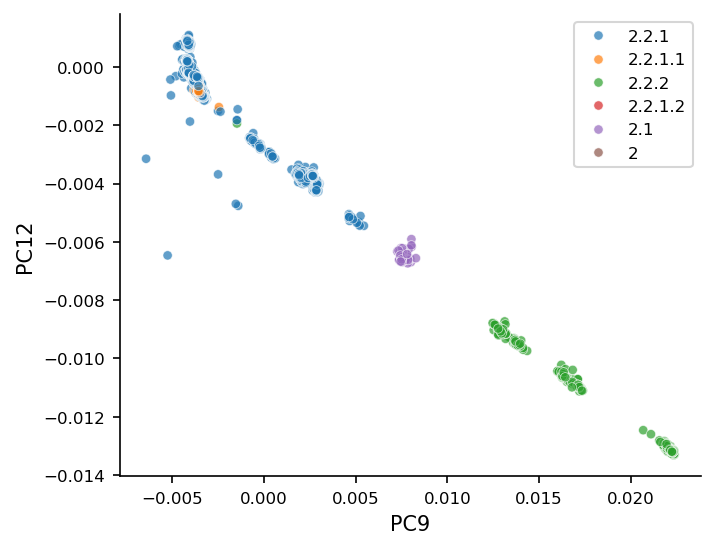

In [30]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC9', pc_y='PC12', 
                            include_lineages=["2"],
                            color_col="Coll2014", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC9_PC12_L2.png'
                           )

In [37]:
lineage_corr_dict['3'].head(20)

,rho,pval,PC,abs_rho,Bonferroni_pval
2,0.871132,0.0,3,0.871132,0.0
1,0.501435,0.0,2,0.501435,0.0
0,0.189171,0.0,1,0.189171,0.0
8,-0.112819,0.0,9,0.112819,0.0
17,-0.071971,0.0,18,0.071971,0.0
11,-0.06389,0.0,12,0.06389,0.0
5,-0.039907,0.0,6,0.039907,0.0
19,-0.038677,0.0,20,0.038677,0.0
3,-0.030178,0.0,4,0.030178,0.0
10,-0.028373,0.0,11,0.028373,0.0


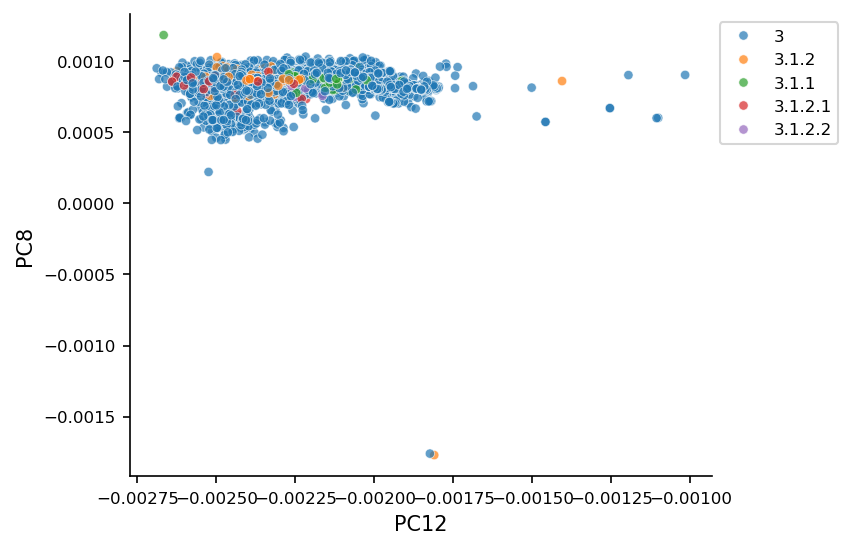

In [49]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC12', pc_y='PC8', 
                            include_lineages=["3"],
                            color_col="Coll2014", 
                            color_dict=LinToColor_Dict, 
                            #saveName='PC1_PC2_single_lineages.png'
                           )

In [53]:
eigenvec_df.loc[single_lineages.query("Lineage=='3'").Sample_ID.values]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
sample_id,,,,,,,,,,,,,,,,,,,,,
57986,0.001754,0.003488,0.010742,-0.000547,0.000079,-0.001248,-0.000439,0.000891,-0.003383,0.000037,...,-0.001952,0.007718,-0.002296,0.001598,0.006075,-0.005119,-0.001291,-0.002917,-0.004087,-0.000910
16030,0.001772,0.003459,0.010747,-0.000500,0.000107,-0.001189,-0.000455,0.000809,-0.003409,-0.000040,...,0.000036,0.004203,0.001362,0.001015,0.009490,-0.005021,0.001088,-0.007318,0.000750,-0.002083
25337,0.001785,0.003474,0.010726,-0.000501,0.000072,-0.001172,-0.000485,0.000862,-0.003355,0.000036,...,-0.002570,0.004300,-0.003085,0.000992,0.011792,-0.008201,0.002162,-0.002373,-0.000889,-0.000973
133896,0.001766,0.003441,0.010741,-0.000487,0.000097,-0.001211,-0.000374,0.000867,-0.003287,0.000045,...,-0.003453,-0.002876,-0.001187,-0.000385,-0.003620,0.002871,-0.001996,-0.001223,0.001614,-0.002425
65656,0.001794,0.003441,0.010736,-0.000531,0.000073,-0.001188,-0.000483,0.000775,-0.003352,0.000056,...,-0.003480,0.007351,0.000651,0.002110,0.007072,-0.003189,0.003020,0.000198,-0.001185,-0.002386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155492,0.001793,0.003475,0.010723,-0.000494,0.000079,-0.001068,-0.000511,0.000790,-0.003372,0.000019,...,-0.014628,-0.007738,0.000012,-0.002295,0.001295,0.001937,-0.001030,0.001932,0.002253,-0.000615
155511,0.001727,0.003448,0.010767,-0.000510,0.000141,-0.001229,-0.000372,0.000922,-0.003318,0.000014,...,-0.000599,-0.001573,-0.001178,0.000428,-0.002226,0.000371,-0.000087,-0.000506,-0.000787,0.001845
155606,0.001796,0.003461,0.010728,-0.000482,0.000101,-0.001022,-0.000508,0.000794,-0.003357,0.000099,...,-0.016875,-0.006928,0.000957,-0.001688,0.001392,0.003360,0.000014,0.002527,0.001843,0.003657


In [92]:
lineage_corr_dict["1"].query("abs_rho >= 0.1 & PC > 10").sort_values("abs_rho", ascending=False)

,rho,pval,PC,abs_rho,Bonferroni_pval
11,-0.255481,0.0,12,0.255481,0.0
12,-0.242812,0.0,13,0.242812,0.0
14,-0.240683,0.0,15,0.240683,0.0
27,-0.216566,0.0,28,0.216566,0.0
13,-0.215431,0.0,14,0.215431,0.0
26,-0.20933,0.0,27,0.20933,0.0
29,-0.194224,0.0,30,0.194224,0.0
22,-0.182905,0.0,23,0.182905,0.0
20,-0.173841,0.0,21,0.173841,0.0
25,0.164599,0.0,26,0.164599,0.0


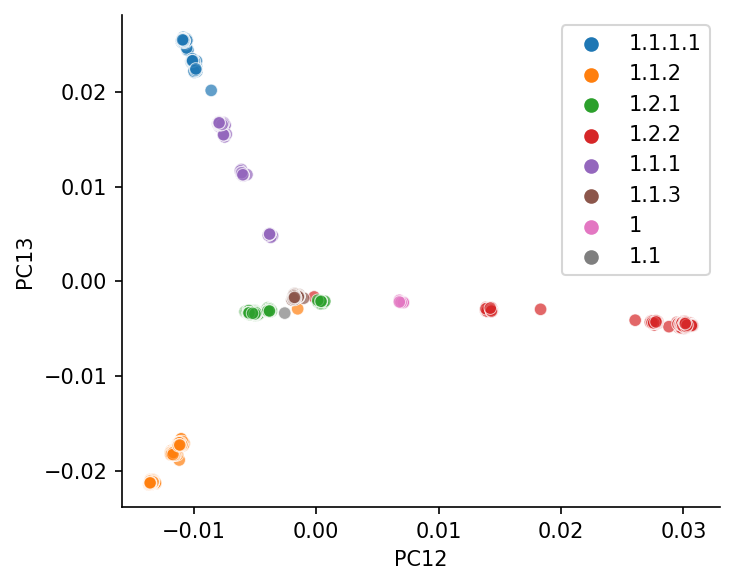

In [98]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC12', pc_y='PC13', 
                            include_lineages=["1"],
                            color_col="Coll2014", 
                            color_dict=None, 
                            #saveFig='PC1_PC2_single_lineages.png'
                           )

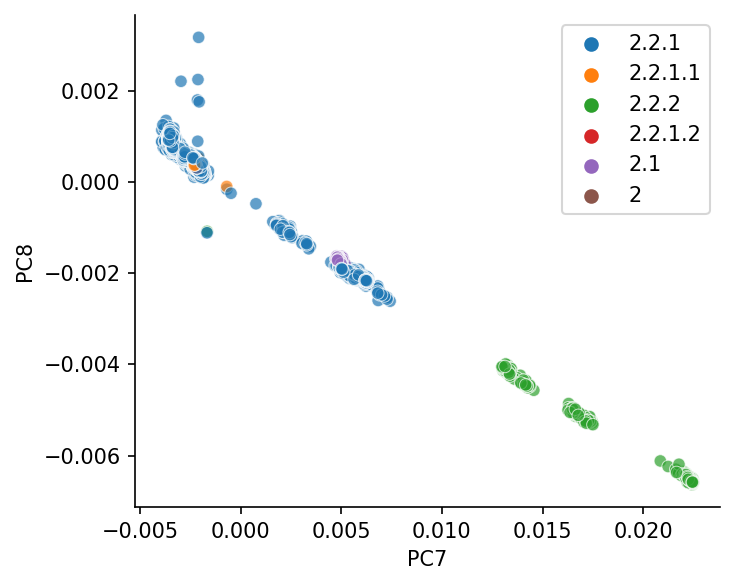

In [61]:
plot_PCA_colored_by_lineage(single_lineages, ['2'], eigenvec_df,
                            color_col="Coll2014", #color_dict=LinToColor_Dict, 
                            pc_x='PC7', pc_y='PC8', 
                            #saveFig='PC1_PC2_single_lineages.png'
                           )

# 0. Levofloxacin Lineage PC Investigation

## A. Plot coefficients with 5 PCs vs. 10/20/50/100
## B. Compare classifications -- make the 5 x 5 table like for comparing regression and SOLO

In [3]:
model_path = os.path.join(analysis_dir, "Levofloxacin", "BINARY", "tiers=1/phenos=WHO/dropAF_withSyn_unpooled")

# model_analysis_5PC = pd.read_csv(os.path.join(model_path, "model_analysis.csv"))
# model_analysis_100PC = pd.read_csv(os.path.join(model_path, "model_analysis_100PC.csv"))
# LRT_100PC = pd.read_csv(os.path.join(model_path, "LRT_results_100PC.csv"))
# LRT_100PC = add_pval_corrections(LRT_100PC.iloc[1:, ])

In [4]:
def combine_permutation_and_LRT(model_path, num_PCs):
    
    if num_PCs == 5:
        suffix = ""
    else:
        suffix = f"_{num_PCs}PC"
        
    model_analysis = pd.read_csv(os.path.join(model_path, f"model_analysis{suffix}.csv"))
    LRT_results = pd.read_csv(os.path.join(model_path, f"LRT_results{suffix}.csv"))
    
    if "mutation" not in LRT_results.columns:
        LRT_results.rename(columns={LRT_results.columns[0]: "mutation"}, inplace=True)
    
    LRT_results = add_pval_corrections(LRT_results.iloc[1:, ])
    
    return model_analysis.merge(LRT_results[["mutation", "BH_pval", "neutral_BH_pval"]].rename(columns={"BH_pval": "LRT_BH_pval"}), on="mutation")
#     final["PC"] = num_PCs
    
#     return final

In [5]:
def add_significance_category(df, tiers_lst, phenos_name, num_PCs):
    '''
    Add significance category annotations, in the form of integers. Add the ones with the fewest requirements first, and then progressively add
    '''
        
    if num_PCs != 5:
        col_name = f"regression_confidence_{num_PCs}PC"
    else:
        col_name = "regression_confidence"
    
    # lower significance threshold for tier 2 genes and if fit on ALL phenotypes
    if len(tiers_lst) == 2 or phenos_name == "ALL":
        thresh = 0.01
    else:
        thresh = 0.05
    
    # uncertain = significant coefficient, but it could be positive or negative
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] > 1), col_name] = "Possible Assoc w R"
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] < 1), col_name] = "Possible Assoc w S"
    
    # df.loc[(df[col_name] == "Possible Assoc w R") & 
    #        (df["LRT_BH_pval"] < thresh) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - rare"
    
    df.loc[(df[col_name] == "Possible Assoc w R") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - strict"
    
    # df.loc[(df[col_name] == "Possible Assoc w S") & 
    #        (df["LRT_BH_pval"] < thresh) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - rare"
    
    df.loc[(df[col_name] == "Possible Assoc w S") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - strict"

    # neutral mutations: not significant in regression AND significant in the neutral LRT test AND present at high enough frequency
    # should be in the lowest tail of the p-value.
    # so a mutation is significant in regression if p-value < 0.05, then a mutation is significant in the neutral test if p-value > 0.95
    # This means that more than 95% of permuted samples are NOT AS EXTREME as the test statistic, indicating the probably the test statistic is not significant
    df.loc[(df["BH_pval"] > (1-thresh)) & (df["neutral_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5), col_name] = "Neutral"
    
    # ALSO REPLACE THE UPPER OR LOWER BOUND OF THE ODDS RATIO WITH 1, DEPENDING ON THE DIRECTION
    df = df.reset_index(drop=True)

    df[col_name] = df[col_name].fillna("Uncertain")
    
    if num_PCs != 5:
        return df.rename(columns={"coef": f"coef_{num_PCs}PC"})
    else:
        return df

# 0. Look at Lineage Distribution for Individual Mutations

## what percentage of each lineage have this variant, independent of any phenotype. Ideally in the BDQ data binary dataset that was used to estimate its effect that we report in the slides



In [39]:
BDQ_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))
bdq_mic = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_mic.csv"))
bdq_phenos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_binary.csv"))

In [55]:
var = "mmpL5_p.Thr794Ile"

# search_samples = set(BDQ_matrix.loc[BDQ_matrix[var]==1].index.values).intersection(bdq_mic.sample_id.values)
search_samples = BDQ_matrix.loc[BDQ_matrix[var]==1].index.values
print(len(search_samples))

final = pd.DataFrame(single_lineages.query("sample_id in @search_samples & ~Coll2014.str.contains(',')")["Lineage"].value_counts()).reset_index()
final = final.rename(columns={"index":"Lineage", "Lineage":f"{var}_Count"}).sort_values("Lineage")

1303


In [56]:
final

,Lineage,mmpL5_p.Thr794Ile_Count
2,1,109
0,2,875
1,3,307
3,BOV_AFRI,2


In [64]:
pd.DataFrame(single_lineages.merge(bdq_phenos.query("phenotypic_category=='WHO'"), on="sample_id")).Lineage.value_counts()

2           949
4           741
3           330
1           117
BOV_AFRI      2
Name: Lineage, dtype: int64

# 1. Numbers of R and S Isolates in each Model

In [3]:
def compute_number_of_isolates_per_model(drug, phenos_name, tiers_lst):
    
    fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
    
    if os.path.isfile(fName):
        model_matrix = pd.read_pickle(fName)

        samples = model_matrix.index.values
        del model_matrix

        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).query("sample_id in @samples")    
        return len(df_phenos.query("phenotype==1")), len(df_phenos.query("phenotype==0"))
    else:
        return 0, 0

In [4]:
RS_counts_tier1 = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):
    
    num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1"])
    num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1"])
    
    RS_counts_tier1.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

In [5]:
# RS_counts_tier1.to_csv("/home/sak0914/RS_counts_tier1.csv", index=False)
RS_counts_tier1

,Drug,WHO_Num_R,WHO_Num_S,ALL_Num_R,ALL_Num_S
0,Amikacin,1108,7619,2429,21602
1,Bedaquiline,763,1247,879,12984
2,Capreomycin,1299,8500,2024,15267
3,Clofazimine,213,4787,674,14181
4,Delamanid,51,514,246,11398
5,Ethambutol,6417,26112,9318,35284
6,Ethionamide,2161,3808,5129,15640
7,Isoniazid,13381,21433,20901,27725
8,Kanamycin,1589,6195,3492,20399
9,Levofloxacin,2568,9629,5562,21550


In [6]:
# counts are a little lower generally than tier 1 because there are more mutations across which there can be missingness, so more isolates were dropped
# RS_counts_tier12 = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

# for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):
    
#     num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1", "2"])
#     num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1", "2"])
    
#     RS_counts_tier12.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

# 2. Lineage Counts per Drug Model

In [12]:
create_lineage_summary_df(single_lineages)

,Lineage,Count
0,1,4062
1,2,15829
2,3,5621
3,4,22730
4,Other,354


In [10]:
def compute_number_of_lineages_per_model(drugs_lst, lineages_df):
    
    lineage_summaries_by_drug = []
    
    for drug in drugs_lst:
        
        # fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
        fName = os.path.join(analysis_dir, drug, "phenos_binary.csv")

        if os.path.isfile(fName):
#             model_matrix = pd.read_pickle(fName)

#             samples = model_matrix.index.values
#             del model_matrix
            df_phenos = pd.read_csv(fName)
            samples = df_phenos["sample_id"].values
        
            single_drug_lineage_summary = create_lineage_summary_df(lineages_df.query("sample_id in @samples"), other_thresh=0.01)
            single_drug_lineage_summary["Drug"] = drug_abbr_dict[drug]

            lineage_summaries_by_drug.append(single_drug_lineage_summary)
        
    return pd.concat(lineage_summaries_by_drug, axis=0)

In [11]:
single_drug_lineage_summary = compute_number_of_lineages_per_model(os.listdir(analysis_dir), single_lineages)

In [17]:
single_drug_lineage_summary.pivot(index="Drug", columns="Lineage", values="Count")#.to_csv("ALL_isolates_by_lineage.csv")

Lineage,1,2,3,4,Other
Drug,,,,,
AMI,1286,9391,2216,11131,53
BDQ,833,5409,1376,6312,28
CAP,867,7177,1635,7104,25
CFZ,1097,5614,1964,5998,34
DLM,723,4335,1223,5350,29
EMB,3446,12867,4525,20791,321
ETH,1204,7812,1967,8694,47
INH,3669,14350,4985,21509,310
KAN,1334,9096,2275,10530,55


In [13]:
def create_stacked_percent_bar_chart(df, xvar, quantVar, hueVar, saveName=None):
    
    LinToColor_Dict = {"1": "#f381b2",
                       "2": "#006dbb",
                       "3": "#9f5eab",
                       "4": "#f6472b",
                       "5": "#76400e",
                       "Other": "white"
                      }
    
#     LinToColor_Dict = {"1": "#DF83AC",
#                    "2": "#7098CB",
#                    "3": "#815D9F",
#                    "4": "#E76956",
#                    "5": "#B67548",
#                    "6": "#6AB79E",
#                    "8": "#E4515B",
#                    "Other": "black"
#                       }
    
    # set the figure size
    fig, ax = plt.subplots(figsize=(12, 4))

    # # dataframe of total counts by lineage
    # total = df.groupby(xvar)[quantVar].sum().reset_index()

    lineage_stacked_for_plotting = df.pivot(index="Drug", columns="Lineage", values="Count")
    lineage_stacked_for_plotting["Total"] = lineage_stacked_for_plotting.sum(axis=1)
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.fillna(0)

    # compute proportions for plotting
    for lineage in df["Lineage"].unique():
        lineage_stacked_for_plotting[lineage] = lineage_stacked_for_plotting[lineage] / lineage_stacked_for_plotting["Total"]
        
    del lineage_stacked_for_plotting["Total"]
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.reset_index().melt(id_vars="Drug")
        
    # keep track of all the groups to increase the start value of the next bar
    prev_vals_array = np.zeros(len(lineage_stacked_for_plotting[xvar].unique()))
    
    # order in increasing lineage abundance for each drug
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.sort_values(["Drug", "value"], ascending=[True, False])
    
    # iterate through the Lineages and convert to percentages
    color_groups = lineage_stacked_for_plotting[hueVar].unique()
    
    for i, color_group in enumerate(color_groups):        
                        
        # dataframe of proportion of each drug's samples that belong to the current lineage
        single_group = lineage_stacked_for_plotting[lineage_stacked_for_plotting[hueVar]==color_group].groupby(xvar)["value"].sum().reset_index()

        if i > 0:
            prev_vals = lineage_stacked_for_plotting[lineage_stacked_for_plotting[hueVar]==color_groups[i-1]].groupby(xvar)["value"].sum().reset_index()["value"].values 
            prev_vals_array += prev_vals
            
        ax.bar(single_group[xvar].values, 
               single_group["value"].values, 
               color=LinToColor_Dict[color_group], 
               bottom = prev_vals_array, 
               edgecolor="black",
               label=color_group,
              )
    
        # the other group is very tiny and not worth plotting
        if color_group != "Other":
            label_loc = 'center'
            annot_format = '{:.2f}'
            ax.bar_label(ax.containers[i], fmt=annot_format, label_type=label_loc, fontsize='9')
    
    plt.setp(ax.patches, linewidth=0.75)
    sns.despine()
    
    bar_scale = 0.85
    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(current_width * bar_scale)
    
    # Rearrange the handles and labels
    handles, labels = ax.get_legend_handles_labels()    
    handles_labels_dict = dict(zip(labels, handles))
    handles_labels_dict = collections.OrderedDict(sorted(handles_labels_dict.items()))

    # Create the legend with the rearranged handles and labels
    ax.legend(list(handles_labels_dict.values()), list(handles_labels_dict.keys()))
    sns.move_legend(ax, fontsize=8, title='Lineage', loc='upper right', #bbox_to_anchor=(1.05, 0.65),
                    ncol=len(color_groups),
                   bbox_to_anchor=(0.65, -0.1))

    if saveName is not None:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')
    else:
        plt.show()

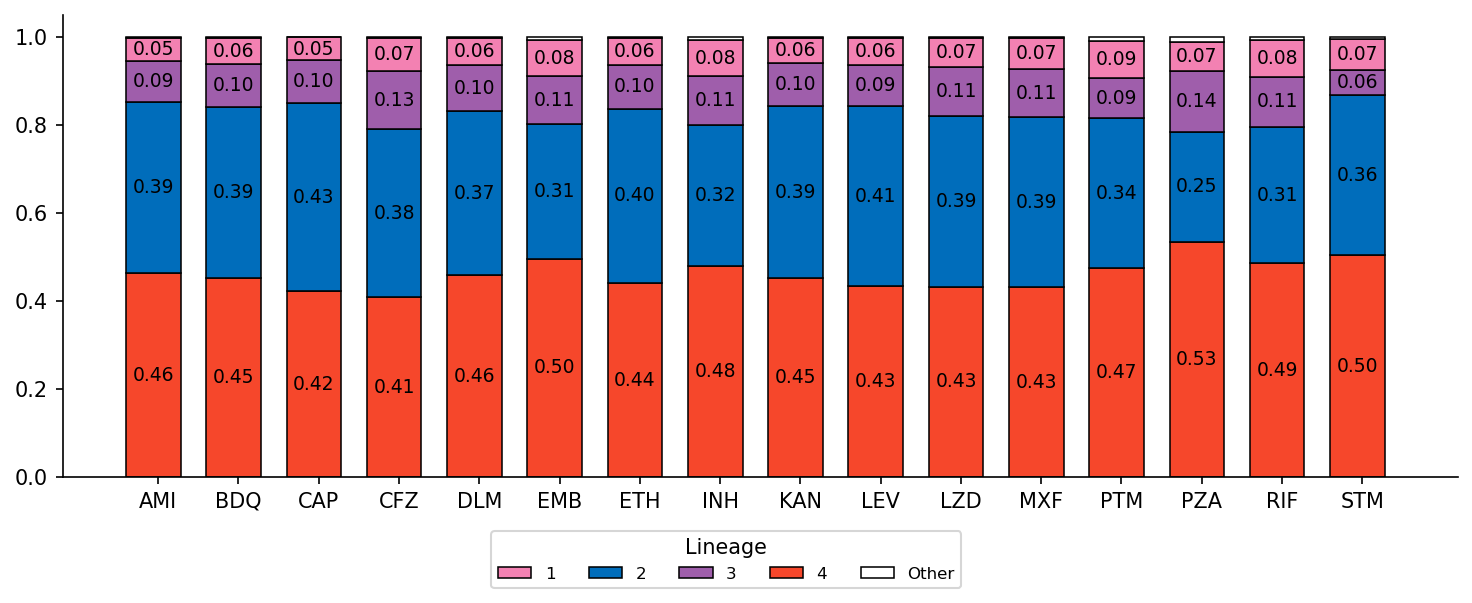

In [14]:
create_stacked_percent_bar_chart(single_drug_lineage_summary, "Drug", "Count", "Lineage", saveName="samples_by_lineage_stacked_bar.png")

In [174]:
def compute_mean_resistance_by_primary_lineage(drug, lineages_df, resist_mean_thresh=0.1):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    
    # combine the lineages dataframe and the phenotypes dataframe for a single drug
    lineages_phenos_combined = lineages_df.merge(df_phenos, on="sample_id")
    # lineages_phenos_combined["L2"] = (lineages_phenos_combined["Lineage"] == "2").astype(int)

    R_summary = pd.DataFrame(lineages_phenos_combined.groupby("Lineage")["phenotype"].mean()).reset_index()

    # other_cols = L2_meanR_summary.query("phenotype < @resist_mean_thresh")["Lineage"].values
    # other_cols = ["BOV", "BOV_AFRI", "canetti"]
    
    # not enough data for L6 and L7. Don't show Bovis on here. L5 has a lot of 0 percent resistant, so doesn't appear a lot on the plot
    keep_cols = (np.arange(5) + 1).astype(str)
    R_summary = R_summary.query("Lineage in @keep_cols")

    R_summary = R_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    R_summary["Drug"] = drug_abbr_dict[drug]
    
    # this column is just to help sort the barplot, just aesthetics
    R_summary["max_R_single_drug"] = np.max(R_summary["phenotype"])
    return R_summary

In [175]:
R_by_lineage = []

for drug in np.sort(os.listdir(analysis_dir)):
    
    R_by_lineage.append(compute_mean_resistance_by_primary_lineage(drug, single_lineages))
    
R_by_lineage = pd.concat(R_by_lineage, axis=0)
assert R_by_lineage["phenotype"].min() <= 1
assert R_by_lineage["phenotype"].max() <= 1
# R_by_lineage = R_by_lineage.pivot(index="Drug", columns="Lineage", values="phenotype")

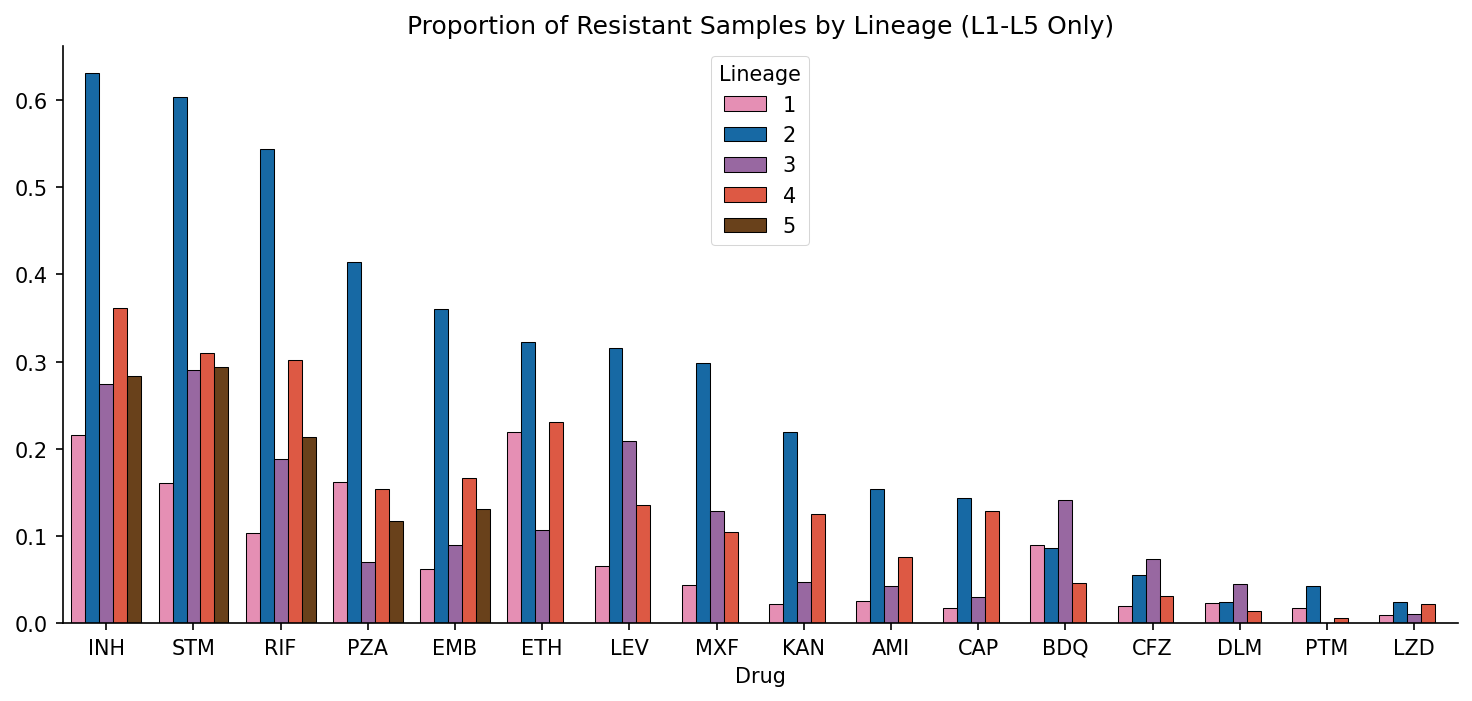

In [203]:
fig, ax = plt.subplots(figsize=(12, 5))

LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e"
                  }

sns.barplot(data=R_by_lineage.sort_values(["max_R_single_drug", "Lineage"], ascending=[False, True]),
            x="Drug",
            y="phenotype",
            hue="Lineage",
            edgecolor="black",
            palette=LinToColor_Dict,
            ax=ax
           )

plt.setp(ax.patches, linewidth=0.5)
plt.legend(title="Lineage", loc="upper center")
plt.ylabel("")
plt.title("Proportion of Resistant Samples by Lineage (L1-L5 Only)")
sns.despine()
plt.savefig("drug_resistance_by_lineage.png", dpi=300)

# 5. INH Compensatory and Neutral Controls

In [12]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]
print(len(np.unique(compens_lst)))

# # 'c.-42T>C' not in dataset, but 'c.-42T>G' is
# neutral_lst = ['c.-88G>A', 'c.-46G>A', 'c.-84T>C', 'c.-42T>C', 'c.-42T>G', 'c.-88G>A', 'c.-10G>A', 'c.33G>A']
# neutral_lst = ["ahpC_" + val for val in neutral_lst]

# print(len(np.unique(compens_lst)), len(np.unique(neutral_lst)))

# INH_genos = pd.read_csv(os.path.join(analysis_dir, "Isoniazid/genos_1.csv.gz"), compression="gzip", usecols=["resolved_symbol", "variant_category"]).drop_duplicates() 
# INH_genos["mutation"] = INH_genos["resolved_symbol"] + "_" + INH_genos["variant_category"]
INH_results = pd.read_csv("../results/FINAL/Isoniazid.csv")

13


In [13]:
INH_results.query("mutation in @compens_lst")[['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'FINAL CONFIDENCE GRADING']].sort_values('ALL_Odds_Ratio', ascending=False)

,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,FINAL CONFIDENCE GRADING
14,ahpC_c.-57C>T,1.164950,0.000000,1.165688,0.000000,Assoc w R
13,ahpC_c.-48G>A,1.168466,0.000000,1.161708,0.000000,Assoc w R
16,ahpC_c.-52C>T,1.138770,0.000000,1.136834,0.000000,Assoc w R
21,ahpC_c.-54C>T,1.125298,0.000000,1.133144,0.000000,Assoc w R
17,ahpC_c.-76T>A,1.138026,0.000000,1.097204,0.000000,Assoc w R
65,ahpC_c.-47_-46insT,1.061279,0.000000,1.083090,0.000000,Uncertain
136,ahpC_c.-72C>T,1.045260,0.000000,1.080957,0.000000,Assoc w R
38,ahpC_c.-52C>A,1.077763,0.000000,1.073249,0.000000,Uncertain
68,ahpC_c.-51G>A,1.059372,0.000000,1.062916,0.000000,Uncertain
36,ahpC_c.-81C>T,1.080169,0.000000,1.042175,0.014000,Uncertain


In [28]:
INH_results.query("mutation in @compens_lst").merge(solo_results[['variant', 'FINAL CONFIDENCE GRADING']].rename(columns={'variant': 'mutation', 'FINAL CONFIDENCE GRADING': 'SOLO FINAL GRADING'}), on='mutation', how='left')[['mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'UNPOOLED CONFIDENCE GRADING', 'POOLED CONFIDENCE GRADING', 'Reason', 'FINAL CONFIDENCE GRADING', 'SOLO FINAL GRADING']].sort_values("FINAL CONFIDENCE GRADING").to_csv("../results/ahpC_compens_controls.csv", index=False)

In [26]:
INH_results.columns

Index(['mutation', 'predicted_effect', 'WHO_Odds_Ratio', 'WHO_BH_pval',
       'WHO_BH_neutral_pval', 'WHO_BH_LRT_pval', 'WHO_BH_LRT_neutral_pval',
       'WHO_Num_Isolates', 'WHO_Present_R', 'WHO_Present_S', 'WHO_Absent_S',
       'WHO_Absent_R', 'WHO_PPV', 'WHO_NPV', 'WHO_Sens', 'WHO_Spec',
       'WHO_PPV_LB', 'WHO_PPV_UB', 'WHO_NPV_LB', 'WHO_NPV_UB', 'WHO_Sens_LB',
       'WHO_Sens_UB', 'WHO_Spec_LB', 'WHO_Spec_UB',
       'Initial confidence grading WHO dataset', 'WHO_single_lineage',
       'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_neutral_pval',
       'ALL_BH_LRT_pval', 'ALL_BH_LRT_neutral_pval', 'ALL_Num_Isolates',
       'ALL_Present_R', 'ALL_Present_S', 'ALL_Absent_S', 'ALL_Absent_R',
       'ALL_PPV', 'ALL_NPV', 'ALL_Sens', 'ALL_Spec', 'ALL_PPV_LB',
       'ALL_PPV_UB', 'ALL_NPV_LB', 'ALL_NPV_UB', 'ALL_Sens_LB', 'ALL_Sens_UB',
       'ALL_Spec_LB', 'ALL_Spec_UB', 'Initial confidence grading ALL dataset',
       'ALL_single_lineage', 'UNPOOLED CONFIDENCE GRADING', 'Reason',
 

# 6. Direct Association-Based Prediction Comparison between SOLO and Regression

<ul>
    <li>SOLO vs. Regression-identified mutations</li>
    <li>Catalog method vs. Regression model</li>
    <li>+/- HETs</li>
</ul>


In [2]:
metrics_components_dict = {'Sens': ['TP', 'FN'],
                           'Spec': ['TN', 'FP'],
                           'F1': [None, None],
                           'PPV': ['TP', 'FP'],
                           'NPV': ['TN', 'FN'],
                          }

# def compute_ci_ztest(plot_df, metric, var1, var2, cat1, cat2):

#     if metric != 'F1':
#         cat1_numerator = plot_df.loc[cat1, var1]
#         cat1_denominator = plot_df.loc[cat1, var1] + plot_df.loc[cat1, var2]
    
#         cat2_numerator = plot_df.loc[cat2, var1]
#         cat2_denominator = plot_df.loc[cat2, var1] + plot_df.loc[cat2, var2]
#     else:
#         cat1_numerator = 2 * plot_df.loc[cat1, 'TP']
#         cat1_denominator = 2 * plot_df.loc[cat1, 'TP'] + plot_df.loc[cat1, 'FP'] + plot_df.loc[cat1, 'FN']

#         cat2_numerator = 2 * plot_df.loc[cat1, 'TP']
#         cat2_denominator = 2 * plot_df.loc[cat1, 'TP'] + plot_df.loc[cat1, 'FP'] + plot_df.loc[cat1, 'FN']

#     twoSided_pval = statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
#                                                                    [cat1_denominator, cat2_denominator]
#                                                                   , alternative='two-sided')[1]

#     if twoSided_pval < 0.05:
#         return twoSided_pval
        
#         # greater_pval = statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
#         #                                                          [cat1_denominator, cat2_denominator]
#         #                                                           , alternative='larger')[1]
#         # if greater_pval < 0.05:
#         #     return greater_pval
#         # else:
#         #     # return less than p-value
#         #     return statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
#         #                                                      [cat1_denominator, cat2_denominator]
#         #                                                       , alternative='smaller')[1]
#     else:
#         # not significant
#         return None
        
        
        
def single_metric_solo_regression_comparison(drugs_lst, metric="Sens", saveName=None):

    fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])
            stats['Drug'] = drug
            solo_single_drug_stats = solo_binary_stats.query("Drug==@drug")
            plot_df.append(pd.concat([solo_single_drug_stats, pd.DataFrame(stats.loc["Catalog"]).T], axis=0).rename(index={'Catalog': 'Regression'}))
    
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1)
    
    # Categories and metric names
    categories = plot_df.index.unique()
    colors = sns.color_palette("Set2").as_hex()[:len(categories)]
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]
        # metric_pval = compute_ci_ztest(single_drug_plot_df, metric, var1, var2, single_drug_plot_df.index.values[0], single_drug_plot_df.index.values[1])
        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[j], label=category, linewidth=0.5, edgecolor='black')
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
        # # Set axis labels and title
        # if metric_pval is not None:

        #     if metric_pval < 0.01:
        #         metric_pval = "{:.0e}".format(metric_pval)
        #     else:
        #         metric_pval = np.round(metric_pval, 2)
            
        #     ax.set_title(f"{drug}:\npval = {metric_pval}", fontsize=10)
        # else:
        #     ax.set_title(f"{drug}:\npval = ns", fontsize=10)

        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

In [3]:
# _ = single_metric_solo_regression_comparison(drugs_lst, metric="F1", saveName="../results/SOLO_Regression_Comparison/F1_score.png")

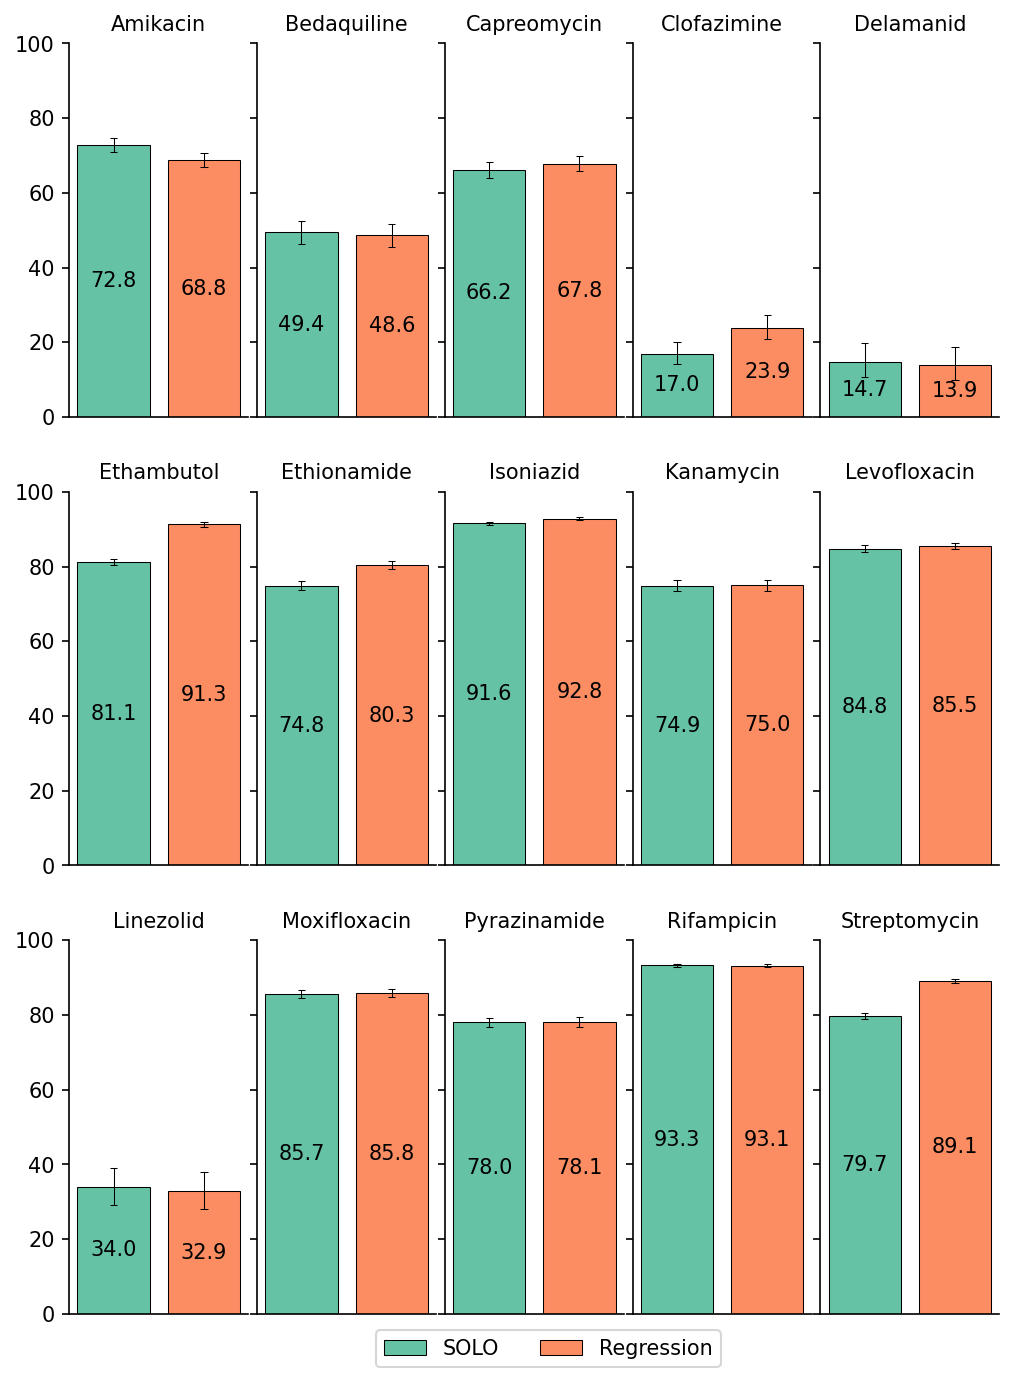

In [4]:
binary_metrics_df = single_metric_solo_regression_comparison(drugs_lst, metric="Sens", saveName="../results/Figures/solo_regression_sensitivity.png")

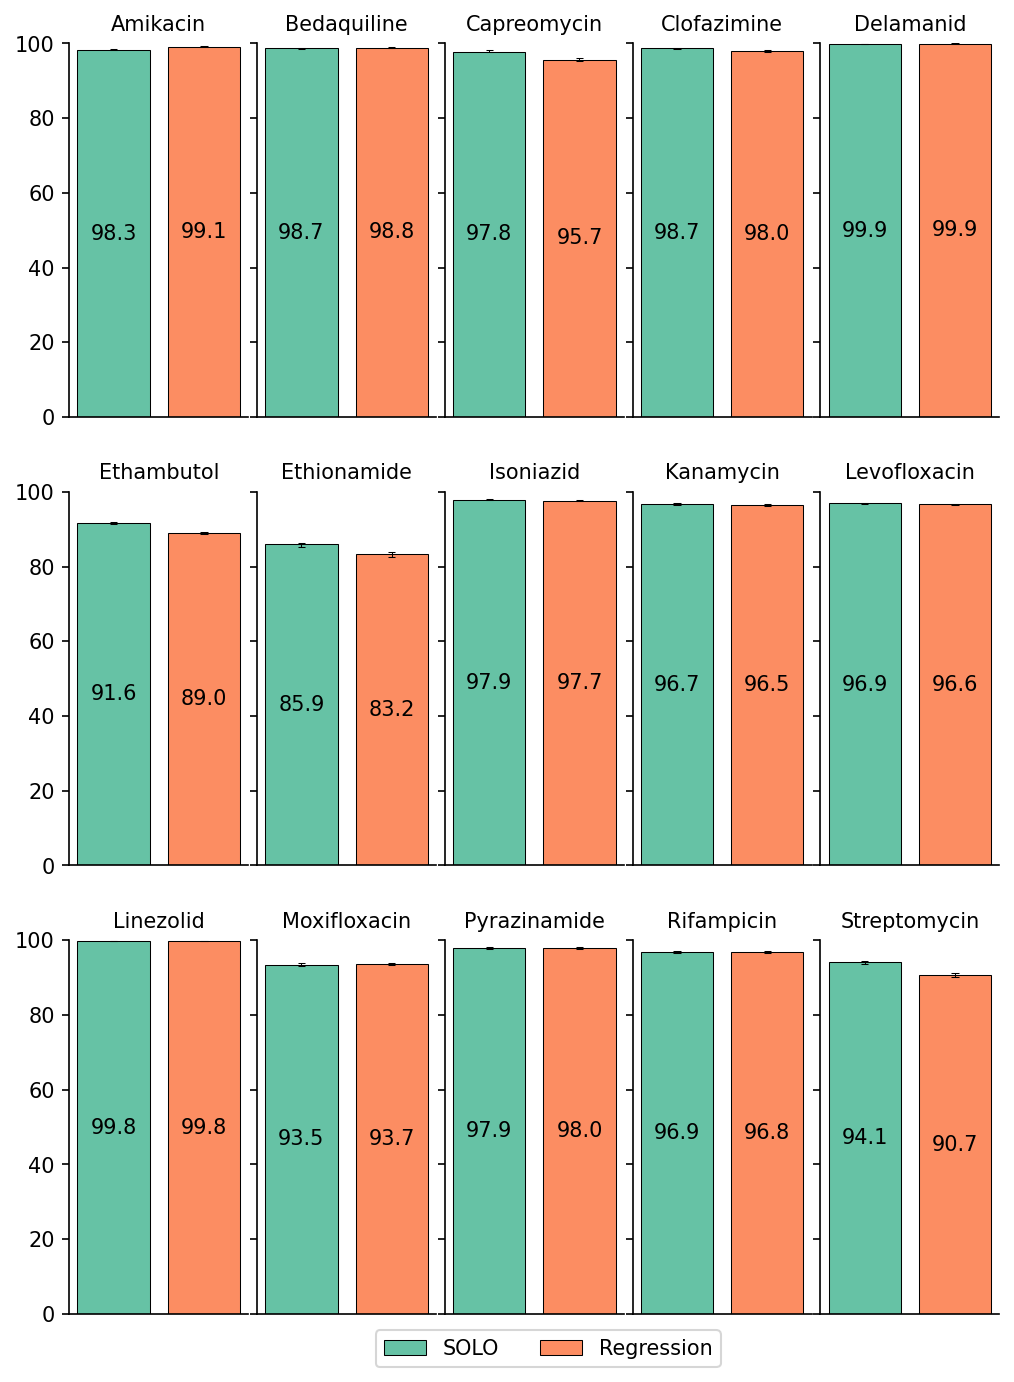

In [5]:
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Spec", saveName="../results/Figures/solo_regression_specificity.png")

In [6]:
diff_df = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df.index.values:

    for metric in diff_df.columns:
        diff_df.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["SOLO", metric]

In [7]:
# regression sensitivity is at least 5 percentage points higher than SOLO, and regression specificity is less than SOLO
diff_df.query("Sens > 0.01 & Spec < 0").sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Ethambutol,0.101752,-0.026481,-0.032511,0.026662,0.021283
Streptomycin,0.094354,-0.034234,-0.035677,0.051644,0.032222
Clofazimine,0.069291,-0.006892,-0.016955,0.002382,0.053836
Ethionamide,0.055282,-0.026633,-0.023593,0.015853,0.007564
Capreomycin,0.015966,-0.021192,-0.126626,0.001481,-0.048311
Isoniazid,0.012452,-0.002491,-0.003431,0.008591,0.005029


In [8]:
# regression sensitivity greater than SOLO and regression specificity less than SOLO
diff_df.query("Sens > 0 & Spec < 0").sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Ethambutol,0.101752,-0.026481,-0.032511,0.026662,0.021283
Streptomycin,0.094354,-0.034234,-0.035677,0.051644,0.032222
Clofazimine,0.069291,-0.006892,-0.016955,0.002382,0.053836
Ethionamide,0.055282,-0.026633,-0.023593,0.015853,0.007564
Capreomycin,0.015966,-0.021192,-0.126626,0.001481,-0.048311
Isoniazid,0.012452,-0.002491,-0.003431,0.008591,0.005029
Levofloxacin,0.007124,-0.002822,-0.008497,0.001997,-0.000581
Kanamycin,0.00135,-0.001598,-0.00651,-0.000074,-0.002433


In [9]:
# regression sensitivity less than SOLO and regression specificity greater than SOLO
diff_df.query("Sens < 0").sort_values("Sens")

,Sens,Spec,PPV,NPV,F1
Amikacin,-0.039694,0.008453,0.071842,-0.003884,0.005045
Linezolid,-0.011123,0.000072,-0.000561,-0.000059,-0.010604
Delamanid,-0.008111,0.000394,0.108333,-0.000451,-0.006129
Bedaquiline,-0.007983,0.001472,0.017466,-0.00054,-0.000297
Rifampicin,-0.001501,-0.000585,-0.00045,-0.000199,-0.001088


In [65]:
drug = "Isoniazid"
regression_results = pd.read_csv(f"../results/FINAL/{drug}.csv")
MIC_results = pd.concat([pd.read_csv(os.path.join(analysis_dir, drug, f"MIC/tiers=1/{model_path}/model_analysis.csv")) for model_path in ['dropAF_noSyn_unpooled', 'dropAF_noSyn_poolSeparate', 'dropAF_withSyn_unpooled']]).drop_duplicates("mutation", keep="first")

# fix LoF naming for merging
MIC_results["mutation"] = [val.replace("lof", "LoF") for val in MIC_results.mutation.values]

regression_mutations_lst = regression_results.loc[regression_results["FINAL CONFIDENCE GRADING"].isin(["Assoc w R", "Assoc w R - Interim"])].mutation.values
solo_mutations_lst = solo_results.query("drug==@drug").loc[solo_results["FINAL CONFIDENCE GRADING"].isin(["1) Assoc w R", "2) Assoc w R - Interim"])].variant.values

regression_results_compare = regression_results.query("mutation in @regression_mutations_lst").merge(MIC_results.rename(columns={'coef': 'MIC_coef', 'BH_pval': 'MIC_BH_pval'})[['mutation', 'MIC_coef', 'MIC_BH_pval']], on='mutation', how='left')

print(len(regression_mutations_lst), len(solo_mutations_lst))

reg_only = list(set(regression_mutations_lst) - set(solo_mutations_lst))
solo_only = list(set(solo_mutations_lst) - set(regression_mutations_lst))
print(len(reg_only), len(solo_only))

58 143
40 125


In [207]:
regression_mutations_lst

array(['ddn_LoF', 'ddn_inframe', 'ddn_p.Leu49Pro'], dtype=object)

In [198]:
#regression_results_compare.loc[pd.isnull(regression_results_compare['MIC_coef'])]

In [200]:
# regression_results_compare.loc[~pd.isnull(regression_results_compare['MIC_coef'])].query("mutation in @reg_only")# & MIC_BH_pval < 0.05")

In [204]:
solo_results.query("variant in @reg_only & drug == @drug")['FINAL CONFIDENCE GRADING'].value_counts()

Series([], Name: count, dtype: int64)

In [14]:
# _ = single_metric_solo_regression_comparison(drugs_lst, metric="PPV", saveName="../results/SOLO_Regression_Comparison/PPV.png")

In [102]:
# _ = single_metric_solo_regression_comparison(drugs_lst, metric="NPV", saveName="../results/SOLO_Regression_Comparison/NPV.png")

In [80]:
# def compare_solo_regression_binary_metrics(drug, metrics=["Sens", "Spec", "PPV", "NPV"], include_reg_model=False, saveName=None):

#     # no SOLO results for Pretomanid, so will get an error
#     if drug == "Pretomanid":
#         print("No SOLO results for Pretomanid")
#         return None
    
#     if drug == "Pretomanid":
#         phenos_name = "WHO"
#     else:
#         phenos_name = "ALL"

#     stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])
#     solo_single_drug_stats = solo_binary_stats.query("drug==@drug")
#     del solo_single_drug_stats["drug"]

#     # compare regression-identified mutations in catalog with regression prediction model
#     if include_reg_model:
#         plot_df = pd.concat([solo_single_drug_stats, stats], axis=0).rename(index={'Catalog': 'Regression\nCatalog'})
#     else:
#         plot_df = pd.concat([solo_single_drug_stats, pd.DataFrame(stats.loc["Catalog"]).T], axis=0).rename(index={'Catalog': 'Regression'})

#     # Categories and metric names
#     categories = plot_df.index.unique()
#     num_metrics = len(metrics)
#     colors = sns.color_palette("Set2").as_hex()[:len(categories)]
    
#     # Bar width and positions
#     bar_width = 0.05
#     bar_positions = np.arange(len(categories))
    
#     # Create subplots for each metric
#     if include_reg_model:
#         fig_width = 10
#     else:
#         fig_width = 7
        
#     fig, axs = plt.subplots(1, num_metrics, figsize=(fig_width, 4), sharey=True)
#     plt.subplots_adjust(wspace=0.15)
    
#     errwidth = 0.04
#     errlinewidth = 0.5
    
#     for i, metric in enumerate(metrics):

#         var1, var2 = metrics_components_dict[metric]
#         metric_pval = compute_ci_ztest(plot_df, var1, var2, plot_df.index.values[0], plot_df.index.values[1])
        
#         ax = axs[i]
        
#         # Plot bars for each category
#         for j, category in enumerate(categories):
    
#             test = plot_df.loc[category][metric] * 100
#             lower = plot_df.loc[category][f"{metric}_lb"] * 100
#             upper = plot_df.loc[category][f"{metric}_ub"] * 100
            
#             # Plot the test value as a bar
#             patch = ax.bar(j, test, color=colors[j], linewidth=0.5, edgecolor='black')
#             ax.bar_label(patch, label_type='center', fmt='%.1f')
            
#             # Plot the confidence interval as a vertical line
#             ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
#             # plot horizontal lines to make the error bars look nicer
#             ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
#             ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
#         # Set axis labels and title
#         if metric_pval is not None:

#             if metric_pval < 0.01:
#                 metric_pval = "{:.0e}".format(metric_pval)
#             else:
#                 metric_pval = np.round(metric_pval, 2)
            
#             ax.set_title(f"{metric}:\npval = {metric_pval}")
#         else:
#             ax.set_title(f"{metric}:\npval = ns")
        
#         # Set x-axis ticks and labels
#         ax.set_xticks(bar_positions)
#         ax.set_xticklabels(categories)
    
#     # Show the plot
#     sns.despine()
#     plt.suptitle(drug)
#     plt.tight_layout()
#     plt.ylim(0, 100)

#     if saveName is None:
#         plt.show()
#     else:
#         plt.savefig(saveName, dpi=300)

In [63]:
# for drug in np.sort(drugs_lst):
#     compare_solo_regression_binary_metrics(drug)

In [17]:
# def compare_hets_regression(drug, metrics=["Sens", "Spec", "PPV", "NPV"], model_type="Catalog", saveName=None):

#     if drug == "Pretomanid":
#         phenos_name = "WHO"
#     else:
#         phenos_name = "ALL"

#     stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])
#     stats_het = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF25.csv"), index_col=[0])
        
#     # compare regression-identified mutations in catalog with regression prediction model
#     plot_df = pd.concat([pd.DataFrame(stats.loc[model_type]).T.rename(index={model_type: '-HETs'}), 
#                          pd.DataFrame(stats_het.loc[model_type]).T.rename(index={model_type: '+HETs'})
#                         ], axis=0)

#     # Categories and metric names
#     categories = plot_df.index.unique()
#     num_metrics = len(metrics)
#     colors = sns.color_palette("Set2").as_hex()[:len(categories)]
    
#     # Bar width and positions
#     bar_width = 0.05
#     bar_positions = np.arange(len(categories))
    
#     # Create subplots for each metric
#     fig_width = 7
        
#     fig, axs = plt.subplots(1, num_metrics, figsize=(fig_width, 4), sharey=True)
#     plt.subplots_adjust(wspace=0.15)
    
#     errwidth = 0.04
    
#     for i, metric in enumerate(metrics):
#         ax = axs[i]
        
#         # Plot bars for each category
#         for j, category in enumerate(categories):
    
#             test = plot_df.loc[category][metric] * 100
#             lower = plot_df.loc[category][f"{metric}_lb"] * 100
#             upper = plot_df.loc[category][f"{metric}_ub"] * 100
            
#             # Plot the test value as a red dot
#             patch = ax.bar(j, test, color=colors[j], linewidth=0.5, edgecolor='black')
#             ax.bar_label(patch, label_type='center', fmt='%.1f')
#             # ax.bar_label(j, test, color=colors[j])
            
#             # Plot the confidence interval as a vertical line
#             ax.vlines(j, lower, upper, color='black', linewidth=1)
    
#             # plot horizontal lines to make the error bars look nicer
#             ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=1)
#             ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=1)

#         var1, var2 = metrics_components_dict[metric]
#         # metric_pval = compute_ci_ztest(plot_df, var1, var2, plot_df.index.values[0], plot_df.index.values[1])

#         # # Set axis labels and title
#         # if metric_pval is not None:

#         #     if metric_pval < 0.01:
#         #         metric_pval = "{:.0e}".format(metric_pval)
#         #     else:
#         #         metric_pval = np.round(metric_pval, 2)
            
#         #     ax.set_title(f"{metric}:\npval = {metric_pval}")
#         # else:
#         #     ax.set_title(f"{metric}:\npval = ns")
#         ax.set_title(metric)
        
#         # Set x-axis ticks and labels
#         ax.set_xticks(bar_positions)
#         ax.set_xticklabels(categories)
    
#     # Show the plot
#     sns.despine()
#     plt.suptitle(drug)
#     plt.tight_layout()
#     plt.ylim(0, 100)

#     if saveName is None:
#         plt.show()
#     else:
#         plt.savefig(saveName, dpi=300)

In [10]:
def single_metric_HET_comparison(drugs_lst, metric="Sens", saveName=None):

    fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])
            stats_het = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF25.csv"), index_col=[0])
        
            combined_df = pd.concat([pd.DataFrame(stats.loc["Catalog"]).T.rename(index={"Catalog": 'AF = 75%'}), 
                                      pd.DataFrame(stats_het.loc["Catalog"]).T.rename(index={"Catalog": 'AF = 25%'})
                                    ], axis=0)
            combined_df['Drug'] = drug
            plot_df.append(combined_df)
        
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1)
    
    # Categories and metric names
    categories = plot_df.index.unique()

    # keep orange color (index 1) for regression, then select the next color for +HETs
    colors = sns.color_palette("Set2").as_hex()[1:3]
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]
        # metric_pval = compute_ci_ztest(single_drug_plot_df, metric, var1, var2, single_drug_plot_df.index.values[0], single_drug_plot_df.index.values[1])
        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[j], label=category, linewidth=0.5, edgecolor='black')
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
        # # Set axis labels and title
        # if metric_pval is not None:

        #     if metric_pval < 0.01:
        #         metric_pval = "{:.0e}".format(metric_pval)
        #     else:
        #         metric_pval = np.round(metric_pval, 2)
            
        #     ax.set_title(f"{drug}:\npval = {metric_pval}", fontsize=10)
        # else:
        #     ax.set_title(f"{drug}:\npval = ns", fontsize=10)

        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

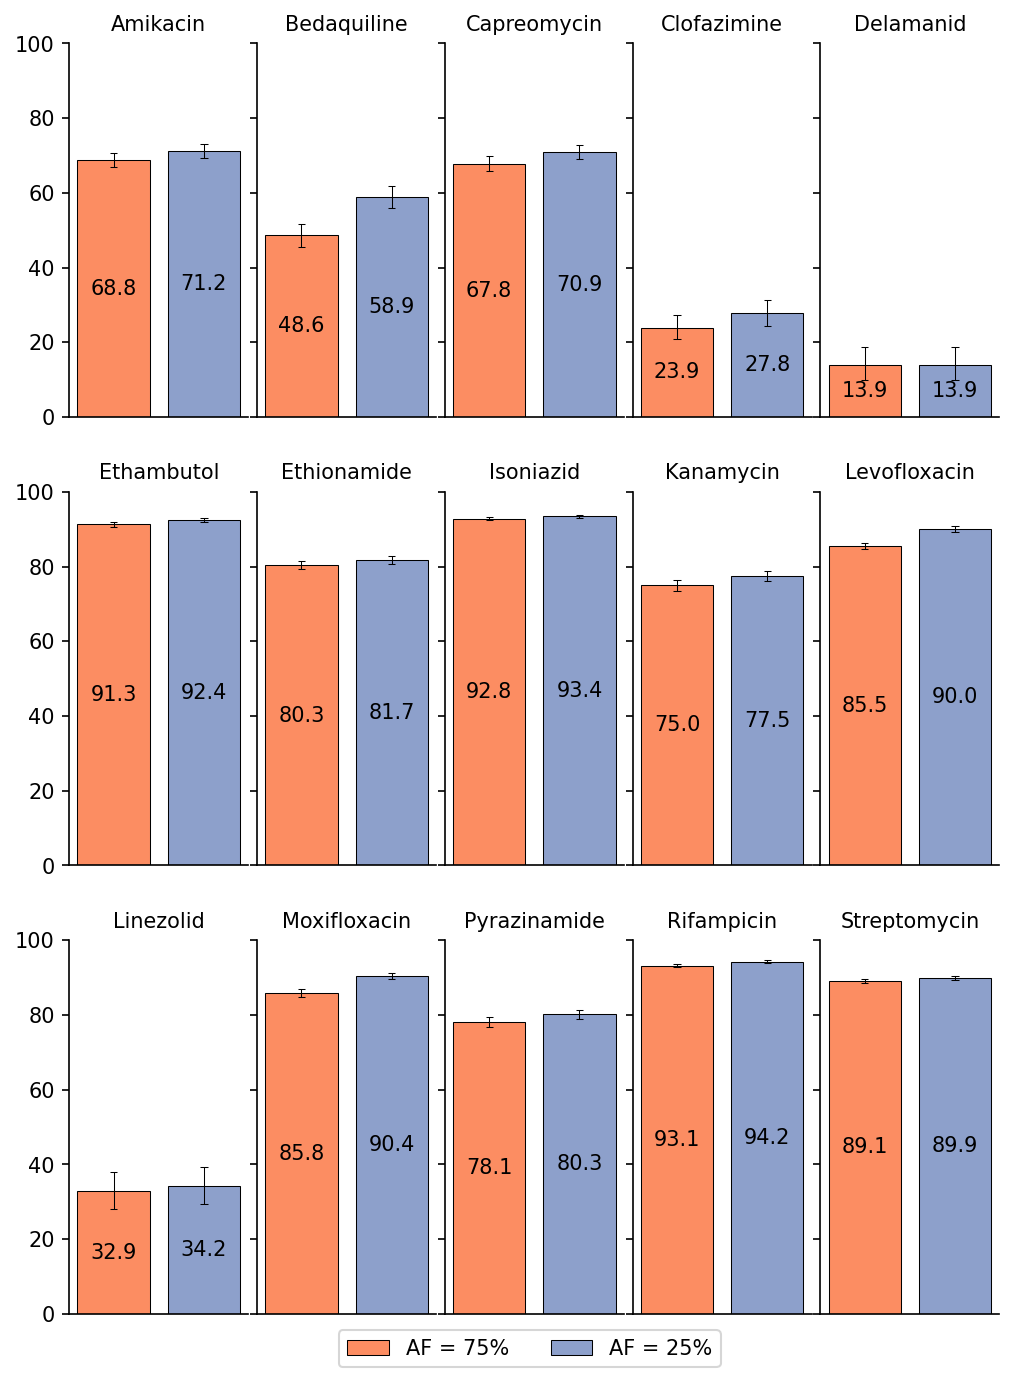

In [11]:
HET_results = single_metric_HET_comparison(drugs_lst, metric="Sens", saveName="../results/Figures/regression_HETs_sensitivity.png")

In [43]:
diff_df_HET = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_HET.index.values:

    for metric in diff_df_HET.columns:
        diff_df_HET.loc[drug, metric] = HET_results.query("Drug==@drug").loc["AF = 25%", metric] - HET_results.query("Drug==@drug").loc["AF = 75%", metric]

In [54]:
HET_results.query("Drug=='Clofazimine'").loc["AF = 25%", ['Sens', 'Sens_lb', 'Sens_ub']]

Sens       0.277696
Sens_lb    0.244252
Sens_ub    0.313091
Name: AF = 25%, dtype: object

In [44]:
diff_df_HET.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Bedaquiline,0.103182,-0.002901,-0.005716,0.007594,0.06947
Moxifloxacin,0.046402,-0.003679,-0.000722,0.010007,0.019025
Levofloxacin,0.044603,-0.002673,-0.002831,0.011606,0.020719
Clofazimine,0.038405,-0.003022,0.001714,0.001636,0.026931
Capreomycin,0.031477,-0.002747,-0.003586,0.003889,0.013409
Kanamycin,0.024377,-0.00138,-0.001202,0.003899,0.011976
Amikacin,0.024194,-0.00099,-0.006967,0.002517,0.012568
Pyrazinamide,0.021214,-0.00225,-0.006669,0.004987,0.009203
Ethionamide,0.013738,-0.003823,-0.001324,0.004465,0.004258
Linezolid,0.013369,-0.000397,-0.026043,0.000271,0.008178


In [45]:
diff_df_HET.query("Sens > 0.01").sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Bedaquiline,0.103182,-0.002901,-0.005716,0.007594,0.06947
Moxifloxacin,0.046402,-0.003679,-0.000722,0.010007,0.019025
Levofloxacin,0.044603,-0.002673,-0.002831,0.011606,0.020719
Clofazimine,0.038405,-0.003022,0.001714,0.001636,0.026931
Capreomycin,0.031477,-0.002747,-0.003586,0.003889,0.013409
Kanamycin,0.024377,-0.00138,-0.001202,0.003899,0.011976
Amikacin,0.024194,-0.00099,-0.006967,0.002517,0.012568
Pyrazinamide,0.021214,-0.00225,-0.006669,0.004987,0.009203
Ethionamide,0.013738,-0.003823,-0.001324,0.004465,0.004258
Linezolid,0.013369,-0.000397,-0.026043,0.000271,0.008178


In [124]:
diff_df_HET.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Clofazimine,0.025727,-0.002953,0.002835,-0.000693,0.018292
Bedaquiline,0.021419,-0.002875,-0.006131,-0.003037,0.011656
Linezolid,0.016605,-0.00039,-0.017321,-0.000129,0.012893
Capreomycin,0.007053,-0.002092,-0.002179,-0.00016,0.002188
Levofloxacin,0.00449,-0.002509,-0.002221,-0.000141,0.001033
Moxifloxacin,0.004178,-0.003254,0.00029,-0.000154,0.001879
Kanamycin,0.003374,-0.00107,-0.000443,-0.000341,0.001494
Pyrazinamide,0.002533,-0.002199,-0.006793,-0.000448,-0.001561
Ethionamide,0.001968,-0.00243,0.00032,-0.000302,0.000927
Amikacin,0.001628,-0.000847,-0.006649,-0.000425,-0.001601


NameError: name 'results_all_drugs' is not defined

In [121]:
HET_results.query("Drug=='Linezolid'").loc['+HETs', ['Sens_lb', 'Sens', 'Sens_ub']]

Sens_lb    0.293168
Sens       0.341463
Sens_ub    0.392326
Name: +HETs, dtype: object

In [118]:
drug = 'Moxifloxacin'
HET_results.query("Drug==@drug").loc[['+HETs', '-HETs'], 'Sens']

+HETs    0.904467
-HETs    0.900289
Name: Sens, dtype: float64

In [119]:
drug = 'Levofloxacin'
HET_results.query("Drug==@drug").loc[['+HETs', '-HETs'], 'Sens']

+HETs    0.899728
-HETs    0.895238
Name: Sens, dtype: float64

# Volcano Plots of MIC Results for Mutations 1) Assoc w R by Regression and Uncertain by SOLO

In [177]:
results_all_drugs = []

for drug in drugs_lst:
    df = pd.read_csv(f"../results/FINAL/{drug}.csv")
    df['Drug'] = drug
    results_all_drugs.append(df)

results_all_drugs = pd.concat(results_all_drugs, axis=0)

# compare lengths. Regression includes inframe mutations
print(results_all_drugs.shape, solo_results.shape)

assocRS_uncertain_muts = results_all_drugs.loc[(results_all_drugs['SOLO FINAL CONFIDENCE GRADING'] == '3) Uncertain significance') & 
                                               (results_all_drugs['FINAL CONFIDENCE GRADING'].isin(['Assoc w R', 'Assoc w S', 'Assoc w R - Interim', 'Assoc w S - Interim']))
                    ]
print(len(assocRS_uncertain_muts))
print(assocRS_uncertain_muts.predicted_effect.unique())

(21799, 56) (21589, 114)
238
['missense_variant' 'frameshift' 'LoF' 'upstream_gene_variant'
 'inframe_deletion' 'start_lost' 'non_coding_transcript_exon_variant']


In [178]:
all_MIC_results = []

for drug in assocRS_uncertain_muts.Drug.unique():

    for model_path in ["dropAF_noSyn_unpooled", "dropAF_noSyn_poolSeparate", "dropAF_withSyn_unpooled"]:
    
        MIC_results = pd.read_csv(os.path.join(analysis_dir, drug, f"MIC/tiers=1/{model_path}/model_analysis.csv"))
        MIC_results["Drug"] = drug
        all_MIC_results.append(MIC_results.rename(columns={"BH_pval": "MIC_BH_pval"})[["Drug", 'mutation', 'coef', 'MIC_BH_pval']])

all_MIC_results = pd.concat(all_MIC_results).drop_duplicates(["Drug", "mutation"], keep="first")
assocRS_uncertain_muts = assocRS_uncertain_muts.merge(all_MIC_results, on=["Drug", "mutation"], how="left")

In [179]:
plot_df = assocRS_uncertain_muts.loc[~pd.isnull(assocRS_uncertain_muts["MIC_BH_pval"])].reset_index(drop=True)

# negative log-p-value
plot_df['log_MIC_BH_pval'] = -np.log(plot_df['MIC_BH_pval'])

# for variants with a p-value of 0, replace with the next smallest p-value
plot_df.loc[plot_df['MIC_BH_pval'] == 0, 'log_MIC_BH_pval'] = -np.log(np.sort(plot_df['MIC_BH_pval'].unique())[1])

plot_df.loc[(plot_df['coef'] > 0) & (plot_df['MIC_BH_pval'] <= 0.05), 'color'] = 'cornflowerblue'
plot_df.loc[(plot_df['coef'] < 0) & (plot_df['MIC_BH_pval'] <= 0.05), 'color'] = 'darkred'
plot_df.loc[plot_df['MIC_BH_pval'] > 0.05, 'color'] = 'lightgray'
print(plot_df.shape)

(196, 60)


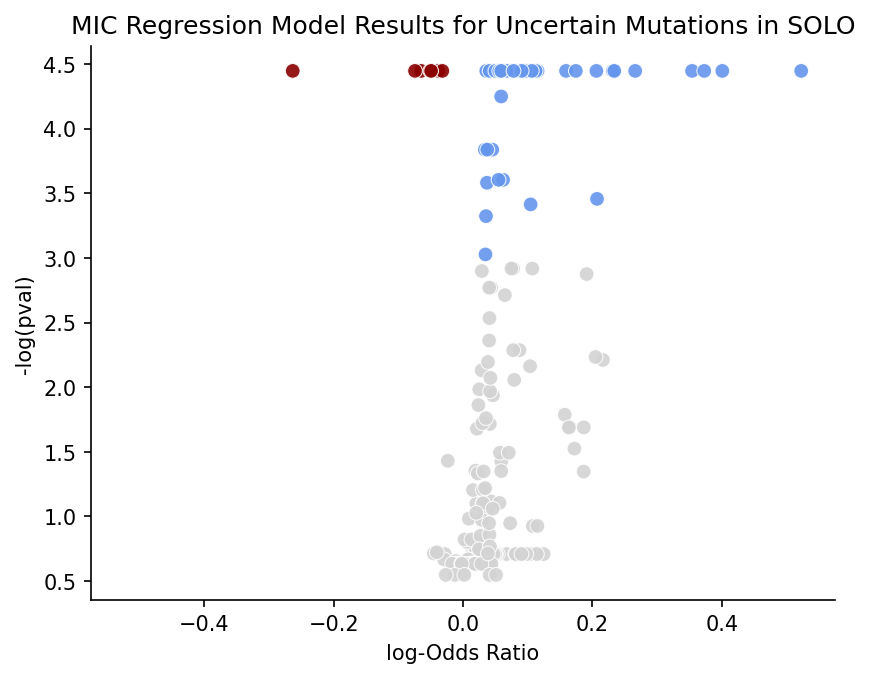

In [185]:
sns.scatterplot(data=plot_df,
                x='coef',
                y='log_MIC_BH_pval',
                hue='color',
                palette={color:color for color in plot_df.color.unique()},
                legend=False,
                alpha=0.9,
                # edgecolor='black',
                linewidth=0.5,
                s=50
               )

max_val = np.max([np.abs(plot_df.coef.min()), np.abs(plot_df.coef.max())]) * 1.1
plt.xlim(-max_val, max_val)

plt.xlabel("log-Odds Ratio")
plt.ylabel("-log(pval)")
plt.title("MIC Regression Model Results for Uncertain Mutations in SOLO")

sns.despine()
plt.show()

In [182]:
plot_df.query("color == 'darkred'").sort_values("coef", ascending=False)[['mutation', 'Drug', 'ALL_Odds_Ratio']]

,mutation,Drug,ALL_Odds_Ratio
43,eis_p.Met1?,Amikacin,0.919272
42,eis_c.-9T>C,Amikacin,0.930728
46,eis_p.Met1?,Kanamycin,0.898020
44,eis_p.His150fs,Amikacin,0.880386
3,Rv1979c_c.-50A>C,Clofazimine,0.906949
47,eis_p.His150fs,Kanamycin,0.876183
1,mmpL5_p.Arg202fs,Bedaquiline,0.915158
